In [1]:
from typing import Any, Union, List

import pytorch_lightning as pl
import torch
from torch.optim import Adam
from model_builder.dataset import CustomDataset, DataModule
from model_builder.utils import DataInstance
from model_builder.schemas import ModelSchema

from mariner.stores.dataset_sql import dataset_store
from mariner.db.session import SessionLocal
import networkx as nx

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [2]:
with SessionLocal() as db:
    [zinc_extra_dataset], total = dataset_store.get_paginated(db, page=1, per_page=1)
df = zinc_extra_dataset.get_dataframe()
with open("../tests/data/yaml/test_model_hard.yaml", "rb") as f:
    f.seek(0)
    model_config = ModelSchema.from_yaml(f.read())

{'type': 'model_builder.layers.Concat', 'name': 'Combiner', 'forward_args': {'x1': '${AddPool}', 'x2': '${Linear1}'}}
<torch.utils.data.dataset.Subset object at 0x7fef5b0ed910> <torch.utils.data.dataset.Subset object at 0x7fef5b0bb3d0> <torch.utils.data.dataset.Subset object at 0x7fef5b0bb430>
{'type': 'model_builder.layers.Concat', 'name': 'Combiner', 'forward_args': {'x1': '${AddPool}', 'x2': '${Linear1}'}}


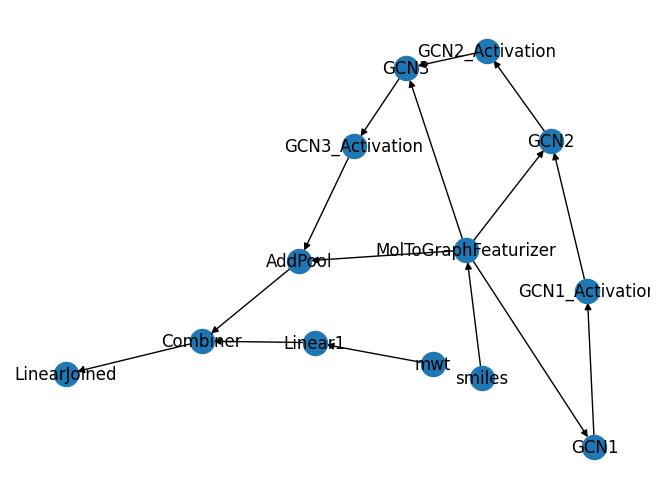

In [11]:
def unwrap_dollar(value: str) -> tuple[str, bool]:
    """
    Takes a string and remove it's reference indicators: $ or ${...}
    Returns the string unwrapped (if it was a reference) and `is_reference` boolean
    """
    if value.startswith("${") and value.endswith("}"):
        return value[2:-1], True
    elif value.startswith("$"):
        return value[1:], True
    return value, False


def collect_args(
    input: DataInstance, args_dict: dict[str, Any]
) -> Union[list, dict, Any]:
    """
    Takes a DataInstance object and a dictionary of args to retrive
    and returns a dictinoraty of resolved arguments.
    Each arg value may be a reference. in such case, the arg value must be
    retrieved from `input`. Otherwise, it's raw value that can be returned as is
    """
    result = {}
    for key, value in args_dict.items():
        if value is None:
            continue
        value, is_ref = unwrap_dollar(value)
        if is_ref:
            attribute, attribute_accessors = (
                value.split(".")[0],
                value.split(".")[1:],
            )
            if attribute == 'input':
                result[key] = input["".join(attribute_accessors)]
                continue
            value = input[attribute]
            if len(attribute_accessors) == 0:
                result[key] = value
                continue
            if 'edge_weight' in attribute_accessors or 'edge_attr' in attribute_accessors:
                continue
            value = value[0] # hack to flatten array of DataBatches (output of Featurizer)
            for attr in attribute_accessors:
                value = getattr(value, attr)
            result[key] = value
        else:
            result[key] = value
    return result

class CustomModelV2(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        layers_dict = {}
        self.config = config
        self.layer_configs = {layer.name: layer for layer in config.layers}
        for layer in config.layers:
            layer_instance = layer.create()
            layers_dict[layer.name] = layer_instance
        self._model = torch.nn.ModuleDict(layers_dict)
        self.graph = config.make_graph()
        self.topo_sorting = list(nx.topological_sort(self.graph))
        self.loss_fn = torch.nn.MSELoss()

    def forward(self, input: DataInstance):
        last = input
        for node_name in self.topo_sorting:
            if node_name not in self.layer_configs:
                continue  # is a featurizer, already evaluated by dataset
            layer = self.layer_configs[node_name]
            args = collect_args(input, layer.forward_args.dict())
            if isinstance(args, dict):
                input[layer.name] = self._model[node_name](**args)
            elif isinstance(args, list):
                input[layer.name] = self._model[node_name](*args)
            else:
                input[layer.name] = self._model[node_name](args)
            last = input[layer.name]
        return last

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)

    def test_step(self, batch, batch_idx):
        prediction = self(batch).squeeze()
        loss = self.loss_fn(prediction, batch["y"])
        # self.logger.log('test_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        prediction = self(batch).squeeze()
        loss = self.loss_fn(prediction, batch["y"])
        return loss

    def training_step(self, batch, batch_idx):
        prediction = self(batch).squeeze()
        loss = self.loss_fn(prediction, batch["y"])
        self.log(
            "train_loss", loss, batch_size=len(batch["y"]), on_epoch=True, on_step=False
        )
        return loss


model = CustomModelV2(model_config)
data_module = DataModule(
    featurizers_config=model_config.featurizers, # model_builder.DatasetConfig
    data=zinc_extra_dataset.get_dataframe(), # mariner.Dataset
    dataset_config=model_config.dataset, # model_builder.DatasetConfig
    split_target=zinc_extra_dataset.split_target, # mariner.Dataset
    split_type=zinc_extra_dataset.split_type, # mariner.Dataset
)
data_module.setup()
nx.draw(model_config.make_graph(), with_labels=True)

In [13]:
from pytorch_lightning import Trainer
trainer = Trainer(max_epochs=3)
trainer.fit(model, data_module.train_dataloader())

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | _model  | ModuleDict | 9.9 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
9.9 K     Trainable params
0         Non-trainable params
9.9 K     Total params
0.040     Total estimated model params size (MB)


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.04it/s, loss=554, v_num=3]
